# Combine IDOC population data sets

IDOC publishes population data sets which consist of each person housed in a state prison each quarter and information about them, such as their demographics, the type of crime they're being held for, the date on which they were apprehended, etc. The data sets are .xls files, but the titles, URLs, and data within each data set differ and need to be cleaned. This script combines all population data sets and makes the information within them consistent.

The population data sets can be found here: https://www2.illinois.gov/idoc/reportsandstatistics/Pages/Prison-Population-Data-Sets.aspx

This was last updated with the Dec 2021 data set as the most recently published data set.

In [1]:
# import packages and set up
from bs4 import BeautifulSoup
parser = 'html.parser'
import urllib.request

import pandas as pd
import numpy as np
from datetime import datetime as dt, date, timedelta as td
import calendar

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
inline_rc = dict(mpl.rcParams)
import plotly.graph_objects as go

import warnings


# suppress warnings
pd.options.mode.chained_assignment = None



In [2]:
# helper function to get list of hex codes from tableau 20 pallette
from pylab import *

def get_hex(n):
    cmap = cm.get_cmap('tab20', n)
    hex_list = []
    for i in range(cmap.N):
        rgb = cmap(i)[:3]  # will return rgba, we take only first 3 so we get rgb
        hex_list.append(matplotlib.colors.rgb2hex(rgb))
        
    return hex_list


# helper function to get rgb code from hex code
def get_rgb_from_hex(hex_code):
    h = hex_code.lstrip('#')
    rgb = tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
    return rgb

Get links to the population data sets from the IDOC site.

In [3]:
resp = urllib.request.urlopen('https://www2.illinois.gov/idoc/reportsandstatistics/Pages/Prison-Population-Data-Sets.aspx')
soup = BeautifulSoup(resp, parser, from_encoding=resp.info().get_param('charset'))

link_list = []
for link in soup.find_all('a', href=True):
    if '.xls' in link['href']:
        link_list.append('https://www2.illinois.gov' + link['href'])
# print(link_list)



Read in and combine the data sets. This takes a bit.

In [4]:
# add each doc date to the df - different url formats need to be read
df_list = []
cnt = 0

for link in link_list:
    cnt += 1
    print(str(cnt) + ' of ' + str(len(link_list)) + ' - ' + link)
    
    # read in the spreadsheet
    df = pd.read_excel(link, skiprows=5)
    
    # format like https://www2.illinois.gov/idoc/reportsandstatistics/Documents/March%202021%20%20Prison%20Stock.xls
    try:
        doc_month_name = link.split(r'Documents/')[1].split(r'%20')[0]
        doc_month_name = doc_month_name[:3]
        doc_month_number = dt.strptime(doc_month_name, "%b").month
        doc_year = int(link.split(r'Documents/')[1].split(r'%20')[1][:4])
        doc_day = calendar.monthrange(doc_year, doc_month_number)[1]
        
    # format like https://www2.illinois.gov/idoc/reportsandstatistics/Documents/Internet%20Data%20Set%20Prison_Stock_Dec_2017.xls
    except:
        try:
            doc_month_name = link.split('_')[2]
            doc_month_name = doc_month_name[:3]
            doc_month_number = dt.strptime(doc_month_name, "%b").month
            try:
                doc_year = int(link.split('_')[3][:4])
            # _Jun%202017
            except:
                doc_year = int(link.split('_')[2].split('%20')[1][:4])
            doc_day = calendar.monthrange(doc_year, doc_month_number)[1]
        
        # format like https://www2.illinois.gov/idoc/reportsandstatistics/Documents/Prison%20Population%206-30-16%20Data%20Set.xls
        except:
            doc_month_number = int(link.split('-')[0].split('%20')[2])
            doc_year = int('20' + link.split('-')[2].split('%20')[0])
            doc_day = calendar.monthrange(doc_year, doc_month_number)[1]
            print(date(doc_year, doc_month_number, doc_day))
            
    # only one format like this
    if link == 'https://www2.illinois.gov/idoc/reportsandstatistics/Documents/Dec%2031%202019%20Prison%20Stock%20pop.xls':
        doc_month_number = 12
        doc_year = 2019
        doc_day = 31
        
    # create the doc date
    df['Doc Date'] = date(doc_year, doc_month_number, doc_day)

    # add the df to the list
    df_list.append(df)
    
# combine the dfs
df = pd.concat(df_list)

df0 = df.copy()

    

1 of 41 - https://www2.illinois.gov/idoc/reportsandstatistics/Documents/December%202021%20Prison%20Stock.xls
2 of 41 - https://www2.illinois.gov/idoc/reportsandstatistics/Documents/September%202021%20Prison%20Stock.xls
3 of 41 - https://www2.illinois.gov/idoc/reportsandstatistics/Documents/June%202021%20Prison%20Stock.xls
4 of 41 - https://www2.illinois.gov/idoc/reportsandstatistics/Documents/March%202021%20%20Prison%20Stock.xls
5 of 41 - https://www2.illinois.gov/idoc/reportsandstatistics/Documents/Dec%202020%20%20Prison%20Stock.xls
6 of 41 - https://www2.illinois.gov/idoc/reportsandstatistics/Documents/Sept%202020%20Prison%20Pop.xls
7 of 41 - https://www2.illinois.gov/idoc/reportsandstatistics/Documents/June%202020%20Prison%20Stock%20Pop.xls
8 of 41 - https://www2.illinois.gov/idoc/reportsandstatistics/Documents/March%202020%20Prison%20Stock.xls
9 of 41 - https://www2.illinois.gov/idoc/reportsandstatistics/Documents/Dec%2031%202019%20Prison%20Stock%20pop.xls
10 of 41 - https://www2.i

**Explore the data**

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1714361 entries, 0 to 44615
Data columns (total 32 columns):
 #   Column                                              Dtype         
---  ------                                              -----         
 0   Unnamed: 0                                          float64       
 1   IDOC #                                              object        
 2   Name                                                object        
 3   Date of Birth                                       object        
 4   Sex                                                 object        
 5   Race                                                object        
 6   Veteran Status                                      object        
 7   Current Admission Date                              object        
 8   Admission Type                                      object        
 9   Parent Institution                                  object        
 10  Projected Mandatory 

**Dedupe/combine columns**

Sometimes, columns in the individual data sets had different names. Combine these into a single column in the combined version.


In [6]:
# remove notes at end of each doc
df = df[~pd.isnull(df['Name'])]
df.reset_index(inplace=True)
df['Idx'] = df.index

# rename dupe columns so they can be consolidated programmatically
df.rename(columns={'Projected Discharge  Date2': 'Projected Discharge Date1', 'Current Admission Type': 'Admission Type1'}, inplace=True)
   
len1 = len(df)
dupe_col_name_list = ['Projected Mandatory Supervised Release (MSR) Date', 'Projected Discharge Date', 'Current Admission Date', 'Admission Type']
for col_name in dupe_col_name_list:
    
    # get the rows where the main col is blank
    blank_col_df = df[pd.isnull(df[col_name])]
    
    # fill the main col with the duped col vals for each dupe col when the main col is blank
    len2 = len(blank_col_df)
    blank_col_fill_df_list = []
    for dupe_num in range(1, 5):
        if col_name + str(dupe_num) in df.columns:
            blank_col_fill_df = blank_col_df[(~pd.isnull(blank_col_df[col_name + str(dupe_num)]))]
            blank_col_fill_df[col_name] = blank_col_fill_df[col_name + str(dupe_num)]
            blank_col_fill_df_list.append(blank_col_fill_df)
            blank_col_df = blank_col_df[~blank_col_df.index.isin(blank_col_fill_df.index)]
    
    # combine the rows that were able to be filled with those that weren't (where the main and all dupe cols were blank)
    all_blank_col_df = blank_col_df.copy()
    blank_col_df = pd.concat(blank_col_fill_df_list)
    blank_col_df = pd.concat([all_blank_col_df, blank_col_df])
    if len(blank_col_df) != len2:
        print('ERROR: ' + col_name + ' length mismatch')
        1/0
        
    # combine rows where the main col was blank with rows where the main col wasn't blank
    non_blank_col_df = df[~pd.isnull(df[col_name])]
    df = pd.concat([blank_col_df, non_blank_col_df])
    if len(df) != len1:
        print('ERROR: Length mismatch')
        1/0

# drop the dupe columns
for col_name in dupe_col_name_list:
    for dupe_num in range(1, 5):
        if col_name + str(dupe_num) in df.columns:
            df.drop(col_name + str(dupe_num), axis=1, inplace=True)

# remove empty columns
for col in df.columns:
    if df[col].isnull().all():
        df.drop(col, axis=1, inplace=True)
    
print(df.columns)
            
# df1 = df.copy()



Index(['index', 'IDOC #', 'Name', 'Date of Birth', 'Sex', 'Race',
       'Veteran Status', 'Current Admission Date', 'Admission Type',
       'Parent Institution', 'Custody Date', 'Sentence Date', 'Crime Class',
       'Holding Offense', 'Holding Offense Category', 'Offense Type',
       'Sentence Years', 'Sentence Months', 'Truth in Sentencing',
       'Sentencing County', 'Doc Date',
       'Projected Mandatory Supervised Release (MSR) Date',
       'Projected Discharge Date', 'Idx'],
      dtype='object')


**Reformat dates**

Some dates are saved as strings. These can be in the format mmddyyyy, mddyyyy, mmdyyyy, yyyymmdd, or some other combination.

NOTE: I needed to guess on some of these by using context clues. Example: Does 1211983 mean 1/21/1983 or 12/1/1983?

In [7]:
len1 = len(df)

def get_date_parts_for_unknown_mmdd(unknown_part_placement_df):
    correct_placement_df_list = []

    for i in range(1, 3):
        unknown_part_placement_df['month'] = unknown_part_placement_df['mmdd'].apply(lambda x: int(x[:i]))
        unknown_part_placement_df['day'] = unknown_part_placement_df['mmdd'].apply(lambda x: int(x[i:]))
        correct_placement_df = unknown_part_placement_df[(unknown_part_placement_df['month'] > 0) & (unknown_part_placement_df['day'] > 0) 
                                                         & (((unknown_part_placement_df['month'].isin([1, 3, 5, 7, 8, 10, 12])) & (unknown_part_placement_df['day'] <= 31))
                                                            | ((unknown_part_placement_df['month'].isin([4, 6, 9, 11])) & (unknown_part_placement_df['day'] <= 30))
                                                            | ((unknown_part_placement_df['month'] == 2) & 
                                                                ((unknown_part_placement_df['day'] <= 28) | ((unknown_part_placement_df['day'] <= 29) & (unknown_part_placement_df['year'] % 4 == 0)))))]
        correct_placement_df_list.append(correct_placement_df)
        
        # get rid of the correct ones for the next iteration, in case they can work both ways
        unknown_part_placement_df = unknown_part_placement_df[~unknown_part_placement_df.index.isin(correct_placement_df.index)]
        
    full_correct_placement_df = pd.concat(correct_placement_df_list)
    
    return full_correct_placement_df


def convert_to_dates(orig_df, col_name, max_year):
    # note: the numbers in the comments are outdated, include data only partially through 2021
    
    # sort the df
    orig_df.sort_values(by='Idx', inplace=True)
    
    # remove nulls
    # ----- 32 for dob, 87758 for discharge -----
    na_date_df = orig_df[pd.isnull(orig_df[col_name])]
    print('\nNA times')
    print(len(na_date_df))
    df = orig_df[~pd.isnull(orig_df[col_name])]
    
    # get data types - 0 NaType for dob, custody date, sentence date
    df['type'] = df[col_name].apply(lambda x: str(type(x)))
    print('\ndata types')
    print(df[['type', col_name]].groupby('type').count())

    # make the floats strings
    float_date_df = df[df['type'] == "<class 'float'>"]
    float_date_df[col_name] = float_date_df[col_name].apply(lambda x: str(int(x)))

    # get only string records
    str_date_df = df[df['type'] == "<class 'str'>"]
    str_date_df = pd.concat([str_date_df, float_date_df])

    # get the timestamp records
    ts_date_df = df[~df.index.isin(str_date_df.index)]

    # null out non-dates and add to na_df
    # ----- 68 for dob, 5 for cad, 38 for custody date, 10 for sentence date, 1765 for msr, 4963 for discharge -----
    #   date string length is 1
    print('\nNA - string length')
    str_date_df['len'] = str_date_df[col_name].apply(lambda x: len(x))
    print(str_date_df[['len', col_name]].groupby('len').count())
    null_str_date_df = str_date_df[str_date_df['len'] == 1]
    na_date_df = pd.concat([na_date_df, null_str_date_df])
    
    #   date string has spaces
    str_date_df = str_date_df[str_date_df['len'] > 1]
    print('\nNA - records with spaces')
    str_date_df[col_name] = str_date_df[col_name].str.strip()
    null_str_date_df = str_date_df[str_date_df[col_name].str.contains(' ')]
    print(len(null_str_date_df))
    na_date_df = pd.concat([na_date_df, null_str_date_df])

    str_date_df = str_date_df[~str_date_df.index.isin(null_str_date_df.index)]
    
    len2 = len(str_date_df)

    
    # # # determine if yyyy is at beginning or end of date strings # # #

    # create fields assuming yyyy is at beginning or end
    str_date_df['year at beginning'] = str_date_df[col_name].apply(lambda x: int(x[:4]))
    str_date_df['year at end'] = str_date_df[col_name].apply(lambda x: int(x[-4:]))
    
    # beginning
    # yyyy is assumed to be at the beginning if it's between 1920 and the max year passed in
    suspected_year_at_beginnning_df = str_date_df[(str_date_df['year at beginning'] >= 1920) & (str_date_df['year at beginning'] <= max_year)]
    
    # set the mm dd yyyy assuming yyyy at beginning
    suspected_year_at_beginnning_df['mmdd'] = suspected_year_at_beginnning_df[col_name].apply(lambda x: x[4:])
    suspected_year_at_beginnning_df['year'] = suspected_year_at_beginnning_df[col_name].apply(lambda x: float(x[:4]))
    
    # test that the mm dd yyyy all are possible and keep those that make sense
    year_at_beginning_df = get_date_parts_for_unknown_mmdd(suspected_year_at_beginnning_df)
    year_at_beginning_df['year placement'] = 'beginning'
    suspected_year_at_beginnning_df['year'] = suspected_year_at_beginnning_df[col_name].apply(lambda x: x[:4])
    
    # end
    # yyyy is at the end if it's not at the beginning and is between 1920 and the max year passed in
    suspected_year_at_end_df = str_date_df[(~str_date_df.index.isin(year_at_beginning_df.index)) & (str_date_df['year at end'] >= 1920) & (str_date_df['year at end'] <= max_year)]
    
    # set the mm dd yyyy assuming yyyy at end
    suspected_year_at_end_df['mmdd'] = suspected_year_at_end_df[col_name].apply(lambda x: x[:-4])
    suspected_year_at_end_df['year'] = suspected_year_at_end_df[col_name].apply(lambda x: float(x[-4:]))
    
    # test that the mm dd yyyy all are possible and keep those that make sense
    year_at_end_df = get_date_parts_for_unknown_mmdd(suspected_year_at_end_df)
    year_at_end_df['year placement'] = 'end'
    suspected_year_at_end_df['year'] = suspected_year_at_end_df[col_name].apply(lambda x: x[-4:])
    
    # other
    # get the items that could not be coverted to a date because setting the yyyy at the beginning or end didn't make sense
    # ----- 38917, formatted like 99989999 -----
    non_date_df = str_date_df[(~str_date_df.index.isin(year_at_beginning_df.index)) & (~str_date_df.index.isin(year_at_end_df.index))]
    print('\nNA - non-dates')
    print(len(non_date_df))
    print(non_date_df[col_name].iloc[0:10])
    na_date_df = pd.concat([na_date_df, non_date_df])
    len2 = len2 - len(non_date_df)
    
    # keep the values where the date can be formed
    str_date_df = pd.concat([year_at_beginning_df, year_at_end_df])
    if len(str_date_df) != len2:
        print('finding the year placement changed the length')
        1/0
    
    
    # # # convert to dates # # #
    
    # pad the date parts where necessary
    for dp in ['year', 'month', 'day']:
        str_date_df[dp] = str_date_df[dp].apply(lambda x: str(int(x)))
        str_date_df['len'] = str_date_df[dp].apply(lambda x: len(x))
        need_to_pad_df = str_date_df[str_date_df['len'] == 1]
        need_to_pad_df[dp] = '0' + need_to_pad_df[dp]
        padded_df = str_date_df[str_date_df['len'] != 1]
        str_date_df = pd.concat([need_to_pad_df, padded_df])

    if len(str_date_df) != len2:
        print('padding dates changed the length')
        1/0

#     print('\nyears')
#     print(str_date_df['year'].unique())
#     print('months')
#     print(str_date_df['month'].unique())
#     print('days')
#     print(str_date_df['day'].unique())
    
    # convert date strings to the same format
    str_date_df[col_name + ' str'] = str_date_df['year'].add('-' + str_date_df['month'])
    str_date_df[col_name + ' str'] = str_date_df[col_name + ' str'].add('-' + str_date_df['day'])
    
    # convert to dates
    str_date_df[col_name] = str_date_df[col_name + ' str'].apply(lambda x: dt.strptime(x, '%Y-%m-%d'))
    
    # drop the date strings
    str_date_df.drop(col_name + ' str', axis=1, inplace=True)
    
    date_df = pd.concat([str_date_df, ts_date_df])
    date_df[col_name] = date_df[col_name].apply(lambda x: x.date())
    
    
    # null out null dates
    na_date_df[col_name] = np.nan
    
    
    # combine string dates with timestamp dates and non-dates
    df = pd.concat([str_date_df, ts_date_df, na_date_df])
        
    return df


# convert dates for each of the listed cols
for col_name in ['Date of Birth', 'Current Admission Date', 'Custody Date', 'Sentence Date', 'Projected Mandatory Supervised Release (MSR) Date', 'Projected Discharge Date']:
    
    print('\n\n\nCONVERTING ' + col_name.upper() + '...')
    
    if col_name[:9] == 'Projected':
        max_year = 2300
    else:
        max_year = int(date.today().year)
    
    df = convert_to_dates(df, col_name, max_year)
    
    if len(df) != len1:
        print('Converting {} to dates changed the length'.format(col_name))
        1/0
        
        
# df2 = df.copy()
  
    




CONVERTING DATE OF BIRTH...

NA times
32

data types
                                                    Date of Birth
type                                                             
<class 'float'>                                            511077
<class 'pandas._libs.tslibs.timestamps.Timestamp'>        1157356
<class 'str'>                                               45571

NA - string length
     Date of Birth
len               
1               68
7           382874
8           173706

NA - records with spaces
0

NA - non-dates
0
Series([], Name: Date of Birth, dtype: object)



CONVERTING CURRENT ADMISSION DATE...

NA times
0

data types
                                                    Current Admission Date
type                                                                      
<class 'float'>                                                     511077
<class 'pandas._libs.tslibs.timestamps.Timestamp'>                 1157388
<class 'str'>                             

**Latest record**

Since the data is produced quarterly, some individuals will be repeated in the data. Get the date of the most recent document in which each individual appears.

In [8]:
len1 = len(df)
blank_date_df = df[pd.isnull(df['Current Admission Date'])]
non_blank_date_df = df[~pd.isnull(df['Current Admission Date'])]

non_blank_date_df['Current Admission Date str'] = non_blank_date_df['Current Admission Date'].apply(lambda x: dt.strftime(x, '%Y%m%d'))
non_blank_date_df['ID'] = non_blank_date_df['IDOC #'].add(non_blank_date_df['Current Admission Date str'])
non_blank_date_df.drop('Current Admission Date str', axis=1, inplace=True)

blank_date_df['ID'] = non_blank_date_df['IDOC #']
df = pd.concat([blank_date_df, non_blank_date_df])

if len(df) != len1:
    print(len(df))
    print(len1)
    print('blanking dates changed the length')
    1/0

# get most recent doc date
doc_date_series = df[['ID', 'Doc Date']]
doc_date_series.rename(columns={'Doc Date': 'Last Doc Date'}, inplace=True)
doc_date_series = doc_date_series.groupby('ID')['Last Doc Date'].max()
df = df.merge(doc_date_series, how='inner', on='ID')

# remove unecessary columns
print(df.columns)
df.drop(['Idx', 'type', 'len', 'year at beginning',
       'year at end', 'mmdd', 'year', 'month', 'day', 'year placement'], axis=1, inplace=True)
# (need to drop Doc Date to remove all duplicates)
        
# remove duplicates
df.drop_duplicates(inplace=True)

# df3 = df.copy()



Index(['index', 'IDOC #', 'Name', 'Date of Birth', 'Sex', 'Race',
       'Veteran Status', 'Current Admission Date', 'Admission Type',
       'Parent Institution', 'Custody Date', 'Sentence Date', 'Crime Class',
       'Holding Offense', 'Holding Offense Category', 'Offense Type',
       'Sentence Years', 'Sentence Months', 'Truth in Sentencing',
       'Sentencing County', 'Doc Date',
       'Projected Mandatory Supervised Release (MSR) Date',
       'Projected Discharge Date', 'Idx', 'type', 'len', 'year at beginning',
       'year at end', 'mmdd', 'year', 'month', 'day', 'year placement', 'ID',
       'Last Doc Date'],
      dtype='object')


**Recidivism calculation**

IDOC changed the way that it records recidivism over the years. Recalculate recidivism as sentence number.

In [9]:
# convert admission date to a datetime
df['Current Admission Date'] = pd.to_datetime(df['Current Admission Date'])

len1 = len(df)

# rank the admission date per person - this is the nth time they've been admitted
df_admis_rank = df[['IDOC #', 'Current Admission Date']].drop_duplicates()
df_admis_rank['Sentence Number'] = df_admis_rank.groupby(['IDOC #'])['Current Admission Date'].rank(ascending=True)

# join back to the full dataframe
df = pd.merge(df, df_admis_rank, on=['IDOC #', 'Current Admission Date'], how='inner')

if len(df) != len1:
    print('ERROR: Adding the sentence number changed the df length')

# df3a = df.copy()



**Sentencing Counties**

* Clean up different versions of county names
* Categorize into regions

In [10]:
pd.set_option('display.max_rows', 107)
tmp_df = df['Sentencing County'].value_counts()
print(tmp_df.sort_index())

# relabel mislabeled counties
df.loc[df['Sentencing County'] == 'Dekalb', 'Sentencing County'] = 'DeKalb'
df.loc[df['Sentencing County'] == 'Dupage', 'Sentencing County'] = 'DuPage'
df.loc[df['Sentencing County'] == 'Lasalle', 'Sentencing County'] = 'LaSalle'
df.loc[df['Sentencing County'].isin(['Out of state', 'Unknown']), 'Sentencing County'] = 'Out of state/Unknown'
                                    
# group into regions  
cook_list = ['COOK']
chi_metro_list = ['DUPAGE', 'LAKE', 'KANE', 'MCHENRY', 'WILL']
north_il_list = ['BOONE', 'BUREAU', 'CARROLL', 'DEKALB', 'GRUNDY', 'HENRY', 'JO DAVIESS', 'KENDALL', 'LASALLE', 'LEE', 'OGLE', 'ROCK ISLAND', 'STEPHENSON', 'WHITESIDE',  'WINNEBAGO']
cent_il_list = ['ADAMS', 'BROWN', 'CALHOUN', 'CASS', 'CHAMPAIGN', 'CHRISTIAN', 'COLES', 'CUMBERLAND', 'DEWITT', 'DOUGLAS', 'EDGAR', 'FORD', 'FULTON', 'GREENE', 'HANCOCK', 'HENDERSON', 'IROQUOIS', 'JERSEY', 'KANKAKEE', 'KNOX', 'LIVINGSTON', 'LOGAN', 'MACON', 'MACOUPIN', 'MARSHALL', 'MASON', 'MCDONOUGH', 'MCLEAN', 'MENARD', 'MERCER', 'MONTGOMERY', 'MORGAN', 'MOULTRIE', 'PEORIA', 'PIATT', 'PIKE', 'PUTNAM', 'SANGAMON', 'SCHUYLER', 'SCOTT', 'SHELBY', 'STARK', 'TAZEWELL', 'VERMILION', 'WARREN', 'WOODFORD']
st_louis_list = ['MADISON', 'ST. CLAIR']
south_il_list = ['ALEXANDER', 'BOND', 'CLARK', 'CLAY', 'CLINTON', 'CRAWFORD', 'EDWARDS', 'EFFINGHAM', 'FAYETTE', 'FRANKLIN', 'GALLATIN', 'HAMILTON', 'HARDIN', 'JACKSON', 'JASPER', 'JEFFERSON', 'JOHNSON', 'LAWRENCE', 'MARION', 'MASSAC', 'MONROE', 'PERRY', 'POPE', 'PULASKI', 'RANDOLPH', 'RICHLAND', 'SALINE', 'UNION', 'WABASH', 'WASHINGTON', 'WAYNE', 'WHITE', 'WILLIAMSON']

df.loc[df['Sentencing County'].str.upper().isin(cook_list), 'Sentencing Region'] = 'Cook'
df.loc[df['Sentencing County'].str.upper().isin(chi_metro_list), 'Sentencing Region'] = 'Chicago Metro'
df.loc[df['Sentencing County'].str.upper().isin(north_il_list), 'Sentencing Region'] = 'North IL'
df.loc[df['Sentencing County'].str.upper().isin(cent_il_list), 'Sentencing Region'] = 'Central IL'
df.loc[df['Sentencing County'].str.upper().isin(st_louis_list), 'Sentencing Region'] = 'St. Louis Metro'
df.loc[df['Sentencing County'].str.upper().isin(south_il_list), 'Sentencing Region'] = 'South IL'

# check for missed counties
print(df[pd.isnull(df['Sentencing Region'])]['Sentencing County'].unique())

df.loc[pd.isnull(df['Sentencing Region']), 'Sentencing Region'] = 'Out of State/Unknown'
       
df4 = df.copy()



Adams            13949
Alexander         1785
Bond              2718
Boone             7332
Brown              352
Bureau            3473
Calhoun            627
Carroll           1098
Cass              1373
Champaign        41035
Christian         4773
Clark             2498
Clay              2520
Clinton           3889
Coles            10286
Cook            838817
Crawford          3034
Cumberland         821
DeKalb            7664
DeWitt            2389
Dekalb               1
Douglas           2581
DuPage           20856
Dupage           27018
Edgar             2835
Edwards           1368
Effingham         4284
Fayette           4245
Ford              1541
Franklin          7026
Fulton            3041
Gallatin           737
Greene            1041
Grundy            2874
Hamilton          1911
Hancock           1792
Hardin             715
Henderson          659
Henry             9564
Iroquois          3006
Jackson           8565
Jasper             762
Jefferson         9030
Jersey     

**Truth In Sentencing**

Clean up the mix of floats and strings, percents and descriptions.

In [11]:
# check TIS values
pd.set_option('display.max_rows', 25)
print(df['Truth in Sentencing'].value_counts())

len1 = len(df)

# convert all to string
df['Truth in Sentencing'] = df['Truth in Sentencing'].astype(str)

# life sentences and SDPs are not included
tis_df = df[(~pd.isnull(df['Truth in Sentencing'])) & (~df['Sentence Years'].isin(['LIFE', 'SDP']))]

# where '%' is in the string, the percent is before, the description is after
tis_pct_df = tis_df[tis_df['Truth in Sentencing'].str.contains('%')]
tis_split = tis_pct_df['Truth in Sentencing'].str.split('%')
tis_pct_df['TIS Pct'] = tis_split.apply(lambda x: float(x[0]) / 100)
tis_pct_df['TIS Desc'] = tis_split.apply(lambda x: x[1].strip())

tis_pct_df['TIS Desc'].replace('', np.nan, inplace=True)

tis_non_pct_df = tis_df[~tis_df.index.isin(tis_pct_df.index)]
tis_df = pd.concat([tis_pct_df, tis_non_pct_df])

# if desc is day-for-day, 50%
tis_df.loc[tis_df['Truth in Sentencing'] == 'Day-for-Day', 'TIS Pct'] = 0.5
tis_df.loc[tis_df['Truth in Sentencing'] == 'Day-for-Day', 'TIS Desc'] = 'Day-for-Day'

# if desc is Missing or null, null pct, and convert to nulls
tis_df.loc[tis_df['Truth in Sentencing'].isin(['Missing', 'nan']), 'TIS Pct'] = np.nan
tis_df.loc[tis_df['Truth in Sentencing'].isin(['Missing', 'nan']), 'TIS Desc'] = np.nan
tis_df.loc[tis_df['Truth in Sentencing'].isin(['Missing', 'nan']), 'Truth in Sentencing'] = np.nan

# if tis is a number, pass to the pct field
tis_df.loc[tis_df['Truth in Sentencing'].isin(['1', '0.85']), 'TIS Pct'] = tis_df.loc[tis_df['Truth in Sentencing'].isin(['1', '0.85']), 'Truth in Sentencing'].astype(float)
tis_df.loc[tis_df['Truth in Sentencing'].isin(['1', '0.85']), 'TIS Desc'] = np.nan

# combine back to full df
non_tis_df = df[~df.index.isin(tis_df.index)]
non_tis_df['TIS Pct'] = np.nan
non_tis_df['TIS Desc'] = non_tis_df['Truth in Sentencing']

df = pd.concat([tis_df, non_tis_df])

# check outcomes
print('\n')
pd.set_option('display.max_rows', 25)
print(tis_df[['Truth in Sentencing', 'TIS Pct', 'TIS Desc']].drop_duplicates())

if len(df) != len1:
    print('ERROR: Splitting TIS changed the df length')
    1/0
    
# df5 = df.copy()



Day-for-Day                    1201388
85%                             230505
100%                            139799
85% Armed Habitual Criminal      19994
0.85                             17972
85% Bodily Harm                  17087
85% Agg Domestic Battery         14329
85% Agg Discharge Firearm        13879
75% Drug-Related Offenses        10902
1                                10187
85% Agg DUI w Death               8454
Missing                           4521
85% Agg Arson                     2976
85% Agg DUI w Bodily Harm         1531
85% Reckless Homicide             1500
85% Agg DUI                       1088
85% Machine Gun                     16
100% Terrorism                       5
85% Terrorism                        2
Name: Truth in Sentencing, dtype: int64


                 Truth in Sentencing  TIS Pct                 TIS Desc
0                               100%     1.00                      NaN
79                               85%     0.85                      NaN
978 

**Holding offenses**
There are a lot of similar but slightly different values here. They need to be bucketed/categorized.
* Some can be bucketed based on the JHA interns' list.
* For the rest, bucket based on keywords found in the holding offense.
    * The order of operations matters. E.g. GUN --> weapon offense must come before POSS --> drug offense, since many weapons offenses include the string POSS.

In [12]:
len1 = len(df)

df['Holding Offense'] = df['Holding Offense'].apply(lambda x: str(x).strip())


# specific holding offenses from interns' list
inj_death_list = ['AB/NEGLECT ELD/DEATH/CAREGIVER', 'AGG BATTERY CHILD <13/GREAT BOD HARM', 'AGG BATTERY OF A CHILD', 'AGG BATTERY W/FIREARM/PERSON', 'AGG BATTERY/CHILD <13/PERM DISABL', 'AGG BATTERY/DISCHARGE FIREARM', 'AGG BATTERY/FIREARM/OFF/FIREMAN', 'AGG BATTERY/GREAT BOD HARM/60+', 'AGG BATTERY/GREAT BOD HARM/FLAME SUBST', 'AGG BATTERY/GREAT BOD HARM/PC OFF', 'AGG BATTERY/GREAT BODILY HARM', 'AGG BATTERY/HARM/PEACE OFFICER', 'AGG BATTERY/MERCHANT', 'AGG BTRY/UNLAWFUL DEL/CON SUB', 'AGG KIDNAPING/INFLICT HARM', 'AGG STALKING/BODILY HARM', 'AGG STALKING/BODILY HARM/2ND', 'AGG VEH HIJACKING/DISCH/HARM', 'AGGRAVATED BATTERY W/FIREARM', 'ARMED ROBBERY/DISCHARGE/HARM', 'DOM BTRY/BOD HARM/4+ PRI CONV', 'DOMESTIC BATTERY/BODILY HARM', 'HEINOUS BATTERY', 'HOME INVASION/CAUSE INJURY', 'HOME INVASION/DISCH FIREARM/HARM', 'INTIMIDATION/PHYSICAL HARM', 'MURDER/2ND DEGREE MURDER', 'MURDER/2ND DEGREE/PROVOCATION', 'MURDER/2ND DEGREE/UNREASON', 'MURDER/HOMICIDE/UNBORN CHILD', 'MURDER/INTENT TO KILL/INJURE', 'MURDER/OTHER FORCIBLE FELONY', 'MURDER/STRONG PROB KILL/INJURE', 'RECKLESS CONDUCT/GREAT BODILY HARM', 'VOLUN MANSL/NEGL-DEATH ANOTHER', 'DRUG INDUCED HOMICIDE', 'AGG DUI BODILY HARM/.10+/CHILD', 'AGG DUI/ACCIDENT/BODILY HARM', 'AGG DUI/ACCIDENT/DEATH', 'AGG DUI/BODILY HARM W/CHILD', 'AGG DUI/DEATH OF ANOTHER', 'AGG DUI/GREAT BODILY HARM', 'INVOL MANSLAUGHTER ATV/BOAT', 'INVOL MANSLAUGHTER FAMILY/BOAT', 'RECKLESS HOMIC/INCLINE/DEATH 2+', 'RECKLESS HOMIC/TRAFFIC CONTROL', 'RECKLESS HOMICIDE', 'RECKLESS HOMICIDE/.08 ALC/DRUG', 'RECKLESS HOMICIDE/ALC/CONVIC', 'RECKLESS HOMICIDE/ALC/DRUG', 'RECKLESS HOMICIDE/KILL 2 INDIV', 'SNOWMB OUI OF ALCOHOL/DEATH', 'INVOL MANSLAUGHTER/FAMILY MEMBER', 'INVOLUNTARY MANSLAUGHTER']
inj_death_unclear_list = ['AGG ASLT PEACE OFF/FIRE/ER WRK', 'AGG ASLT/OP MOTOR VEH/STRUCK', 'AGG ASLT/STATE IL EMP/WEAPON', 'AGG ASSAULT/CORRECTIONAL EMP', 'AGG ASSAULT/DHS EMPLOYEE', 'AGG ASSAULT/DISCH FIREARM MV', 'AGG ASSAULT/OP MOTOR VEH/PC OFF', 'AGG ASSAULT/USE FOREARM/PEACE OFF', 'AGG BATTERY SR CITIZEN >60 YRS', 'AGG BATTERY/CONTROLLED SUB', 'AGG BATTERY/GOVERNMENT EMP', 'AGG BATTERY/INGEST TOXIC SUBST', 'AGG BATTERY/JUDGE/EMT', 'AGG BATTERY/PEACE OFF/FIREMAN', 'AGG BATTERY/PEACE OFFICER', 'AGG BATTERY/PREGNANT/HANDICAPPED', 'AGG BATTERY/PUBLIC PLACE', 'AGG BATTERY/STRANGLE/PREV CONV', 'AGG BATTERY/TRANSIT EMPLOYEE', 'AGG BATTERY/USE DEADLY WEAPON', 'AGG BATTERY/WEAPON/NO FIREARM', 'AGG DISCH FIREARM/PC OFF/FIREMAN', 'AGG DISCH FIREARM/VEH/PC OFF/FRMAN', 'AGG DISCH SILENCER PERSON/VEH', 'AGG DISCHARGE FIREARM/BLDG', 'AGG DISCHARGE FIREARM/OCC BLDG', 'AGG DISCHARGE FIREARM/OCC VEH', 'AGG DOMESTIC BATTERY/STRANGLE', 'AGG INTIMIDATION PEACE OFFICER', 'AGG KIDNAPING ARMED W FIREARM', 'AGG KIDNAPING/CHILD<13/RETARDED', 'AGG KIDNAPING/CONCEAL IDENT', 'AGG ROBBERY/CONTROLLED SUB', 'AGG ROBBERY/INDICATE ARM W/FIR', 'AGG STALKING/VIO REST ORDER', 'AGG VEHICULAR HIJACKING/DISCHARGE', 'AGG VEHICULAR HIJACKING/FIREARM', 'AGG VEHICULAR HIJACKING/HANDICAPPED', 'AGG VEHICULAR HIJACKING/PASS <16 YRS', 'AGG VEHICULAR HIJACKING/WEAPON', 'AGGRAVATED ASSAULT', 'AGGRAVATED BATTERY/NURSE', 'AGGRAVATED BATTERY/STRANGLE', 'AGGRAVATED BATTERY/VICTIM 60+', 'AGGRAVATED DISCHARGE/FIREARM', 'AGGRAVATED DOMESTIC BATTERY', 'AGGRAVATED KIDNAPING/ARMED', 'AGGRAVATED KIDNAPING/RANSOM', 'AGGRAVATED ROBBERY', 'AGGRAVATED TRAFFICKING/BENEFIT', 'AGGRAVATED UNLAWFUL RESTRAINT', 'AGGRAVATED VEHICULAR HIJACKING', 'ARMED ROBBERY', 'ARMED ROBBERY/ARMED W/FIREARM', 'ARMED ROBBERY/DISCH FIREARM', 'ARMED ROBBERY/NO FIREARM', 'ARMED VIOL/CATEGORY I WEAPON', 'ARMED VIOL/CATEGORY II WEAP/1ST', 'ARMED VIOL/CATEGORY II WEAPON', 'ARMED VIOL/CATEGORY III WEAPON', 'CAUSE CHILD/ENDANGERED/2+', 'CHILD ABDUCTN/CONCEAL/DETAIN', 'COMMUNICATE/DETAIN WITNESS', 'CRIM TRES TO RES/PERS PRESENT', 'DISMEMBERING A HUMAN BODY', 'DOM BTRY/CONTACT/3 PRIOR CONV', 'DOMESTIC BATTERY/ CONTACT/PRIOR', 'DOMESTIC BATTERY/PHY CONTACT/2ND+', 'DOMESTIC BATTERY/VIOL PROTECT ORDER', 'GIVE FALSE BOMB/GAS ALARM', 'HABITUAL CRIMINAL/2 PRIOR CL X', 'HARASS JURORS/WITNESSES', 'HARASS WITNESS', 'HARASSMENT BY PHONE/4TH +', 'HOME INVASION', 'HOME INVASION/ARMED W/FIREARM', 'HOME INVASION/ARMED/FORCE', 'HOME INVASION/DANDEROUS WEAP', 'HOME INVASION/DISCH FIREARM', 'HOME INVASION/FIREARM', 'HOME INVASION/SEX OFFENSE', 'HOME INVASION/VIO AGAINST PERS', 'HRSMT/PREVENT/SERV/SAME VIC', 'HRSMT/THREATEN PERSON/KILL', 'HUMAN TRAFFICKING FOR LABOR/BENEFITS', 'INTIMIDATION/CONTEMPT/RIDICULE', 'INTIMIDATION/CRIMINAL OFFENSE', 'INVOL SERVITUDE/THREAT PHYS HARM', 'KIDNAPING ARMED WITH FIREARM', 'KIDNAPING DISCHARGE FIREARM', 'KIDNAPING W FORCE OR THREAT', 'KIDNAPING/SECRETLY CONFINE', 'PHONE HRSMT/LEWD/THREAT KILL', 'RECKLESS DISCH FIREARM/ENDANGERS', 'ROBBERY', 'ROBBERY/SCHOOL/PLACE WORSHIP', 'ROBBERY/VIC HANDICAP / 60+', 'ROBBERY/VIC HANDICAP OR 60+ YR', 'STALKING BY TRANSMITTING THREAT', 'STALKING/PERSON/SURVEILLANCE', 'STALKING/TRANSMITS THREAT/2ND', 'UNLAWFUL RESTRAINT', 'UNLAWFUL VEHICULAR INVASION', 'VEHICULAR HIJACKING', 'VIO ORDER/PRIOR VIO OF ORDER', 'VIOLATE ORDER/PRIOR DOM BATTERY', 'AB/NEGLECT ELDERLY/CAREGIVER', 'ARMED VIOL/CATEGORY II WEAP/2ND+', 'CONTEMPT', 'KIDNAPING/DECEIT OR ENTICE', 'VIOLATE STALKING NO CONTACT/2+', 'CHILD ABDUCT/LURE/VIC<17/PRIOR', 'WINDOW PEEPING 3RD+', 'ATT AGG BATTERY/CHILD <13/PERM DISABL', 'ATT AGG BATTERY/PEACE OFFICER', 'ATT AGG DISCHARGE FIREARM', 'ATT AGG DISCHARGE FIREARM AT VEH', 'ATT AGG DISCHARGE FIREARM OFFICER', 'ATT AGG VEHICLE HIJACK W WEAPON', 'ATT ARMED ROBBERY/ARMED', 'ATT ARMED ROBBERY/NO FIREARM', 'ATT DRUG-INDUCED HOMICIDE', 'ATT HOME INVASION/ARMED W/FIREARM', 'ATT HOME INVASION/FIREARM', 'ATTEMPT AGG BATTERY OF A CHILD', 'ATTEMPT AGG BATTERY/DISCHARGE FIREARM', 'ATTEMPT AGG DISCHARGE/FIREARM', 'ATTEMPT AGG KIDNAPG/CHILD<13/RETARD', 'ATTEMPT AGG KIDNAPING/INFLICT HARM', 'ATTEMPT AGG ROBBERY/INDICATE ARM W/FIR', 'ATTEMPT AGG VEHICULAR HIJACKING', 'ATTEMPT AGGRAVATED ROBBERY', 'ATTEMPT ARMED ROBBERY', 'ATTEMPT ARMED VIO/CATEGORY I WEAPON', 'ATTEMPT DISARM PC OFF/CORR EMP', 'ATTEMPT HARASS JURORS/WITNESSES', 'ATTEMPT HOME INVASION/CAUSE INJURY', 'ATTEMPT INTENT/HOMICIDE/UNBORN CHILD', 'ATTEMPT KIDNAP ARMED W FIREARM', 'ATTEMPT MURDER/INTENT TO KILL/INJURE', 'ATTEMPT MURDER/OTHER FORCIBLE FELONY', 'ATTEMPT MURDER/STRONG PROB KILL/INJURE', 'ATTEMPT ROBBERY', 'ATTEMPT ROBBERY/VIC HANDICAP OR 60+ YR', 'ATTEMPT SOLICITATION/MURDER/FOR HIRE', 'ATTEMPT VEHICULAR HIJACKING', 'CONSP AGGRAVATED ROBBERY', 'CONSP ARMED ROBBERY', 'CONSP MURDER/INTENT TO KILL/INJURE', 'SOLICIT MURDER/INTENT TO KILL/INJURE', 'SOLICITATION ROBBERY', 'SOLICITATION/MURDER', 'SOLICITATION/MURDER/FOR HIRE', 'CONSP ROBBERY', 'ATTEMPT AGG KIDNAP/CONCEAL IDENTITY', 'ATTEMPT KIDNAPING/SECRETLY CONFINE', 'CONSP AGG BATTERY/DISCHARGE FIREARM']
sex_list = ['AGG CHILD PORN/DISSEM FILM', 'AGG CHILD PORN/EXHIBIT', 'AGG CHILD PORN/LEWD EXHIBITION', 'AGG CHILD PORN/PERSON/ANIMAL', 'AGG CHILD PORN/POSS FILM/PHOTO', 'AGG CHILD PORN/POSS FILM/PREV', 'AGG CRIM SEX AB/VIC <18/FAMILY', 'AGG CRIM SEX ABUSE', 'AGG CRIM SEX ABUSE/<5 YR VIC', 'AGG CRIM SEX ABUSE/BODILY HARM', 'AGG CRIM SEX ABUSE/DURING FELONY', 'AGG CRIM SEX ABUSE/FAMILY', 'AGG CRIM SEX ABUSE/FORCE/VIC 9-13', 'AGG CRIM SEX ABUSE/INTELLIG DISABL', 'AGG CRIM SEX ABUSE/VIC <13', 'AGG CRIM SEX ABUSE/VIC 13-16', 'AGG CRIM SEX ABUSE/VIC 13-17', 'AGG CRIM SEX ABUSE/VICTIM <13', 'AGG CRIM SEX ABUSE/VICTIM <9', 'AGG CRIM SEX ASLT/INTEL DISABL', 'AGG CRIM SEX ASLT/THREAT LIFE', 'AGG CRIM SEX ASSAULT/BODILY HARM', 'AGG CRIM SEX ASSAULT/FELONY', 'AGG CRIM SEX ASSAULT/FIREARM', 'AGG CRIM SEX ASSAULT/FORCE VIC9-13', 'AGG CRIM SEX ASSAULT/HANDICAPPED', 'AGG CRIM SEX ASSAULT/RETARDED', 'AGG CRIM SEX ASSAULT/THREAT LIFE', 'AGG CRIM SEX ASSAULT/VIC 60+', 'AGG CRIM SEX ASSAULT/VICTIM <13', 'AGG CRIM SEX ASSAULT/VICTIM <9', 'AGG CRIM SEX ASSAULT/VICTIM >60', 'AGG CRIM SEX ASSAULT/WEAPON', 'AGG CRIM SEXUAL ABUSE/FELONY', 'AGG CRIM SEXUAL ASSAULT/CON SUB', 'AGG CRIM SX AB/VIC 13<18/TRUST', 'AGG CRIM SX ASLT/FORCE VIC9-13', 'AGG IND LIB/CHILD/INFLICT HARM', 'CHILD PORN/FILM/TAPE/PHOTO/ACT', 'CHILD PORN/MOVING DEPICTION', 'CHILD PORN/PERS/ANIM/MOV DPTN', 'CHILD PORN/PERSON/ANIMAL', 'CHILD PORN/POSE/EXHIBITION', 'CHILD PORN/POSS FILM/PHOTOS', 'CHILD PORN/POSS PHOTO/VIC <13', 'CHILD PORN/POSS/MOVING DPTN', 'CHILD PORN/REPRODUCE/MOV DPTN', 'CHILD PORN/REPRODUCE/SELL', 'CHILD PORN/SOL CHILD/MOV DPTN', 'CHILD PORN/SOL/CHILD/APPEAR', 'CHILD PORNOGRAPHY/VICTIM <13', 'CRIM SEX ABUSE/CANT CONSENT/2ND', 'CRIM SEX ASLT/FAM MBR <18/2+', 'CRIM SEX ASLT/FAMILY MEMBER<18', 'CRIM SEX ASLT/FORCE/PREV CONV', 'CRIM SEX ASSAULT/CANT CONSENT', 'CRIM SEX ASSAULT/CANT CONSENT/2ND', 'CRIM SEX ASSAULT/FAMILIES', 'CRIM SEX ASSAULT/FAMILIES/2ND+', 'CRIM SEX ASSAULT/FORCE', 'CRIM SEX ASSAULT/FORCE/2ND+', 'CRIM SEX ASSAULT/SUPERVN VIC 13-17', 'CRIM SEX ASSAULT/VICTIM 13-17', 'CRIM SEX ASSAULT/VICTIM 13-17/2ND', 'CRIM SEXUAL ABUSE/CONSENT', 'CRIM SEXUAL ABUSE/CONSENT/2+', 'CRIMINAL SEX ASSAULT/CONSENT', 'CRIMINAL SEXUAL ABUSE/FORCE', 'DEVIATE SEXUAL ASSAULT', 'GROOMING', 'INDECENT SOL ADULT/<13/PENETRATION', 'INDECENT SOL/AGG CRIM SEX ABUSE', 'INDECENT SOL/CRIM SEX ASSAULT', 'INDECENT SOL/PREDITORY/AGG SEX', 'NONCONSENSUAL  DISSM SEX IMAGE', 'PERMIT SEXUAL ABUSE OF CHILD', 'PRED CRIM SEX ASSLAUT/VICTIM <13', 'PREDATORY CRIM SEX ASSAULT/FIREARM', 'PREDATORY CRIM SEX ASSAULT/HARM', 'PREDATORY CRIMINAL SEXUAL ASSAULT', 'PROM JUV PROST/MINOR <13/RETAR', 'PUBLIC INDECENCY/EXPOSURE/3+', 'RAPE', 'RAPE PRIOR TO 2/1/78', 'SEX RELATIONS WITHIN FAMILIES', 'SEXUALLY DANGEROUS PERSON', 'TRAFFIC SEX SERV MINOR < 17', 'TRAVELING TO MEET A MINOR', 'UNLAWFUL VIDEO/VIC<18/SEX OFF', 'EXPLOIT CHILD/SEX ACT/2ND', 'CUSTODIAL SEXUAL MISCONDUCT', 'INDECENT SOLICIT CHILD/INTERNET', 'ATT AGG CRIM SEX ASSAULT VIC 60+', 'ATT CRIM SEX ASSAULT/FORCE', 'ATT PERMIT SEXUAL ABUSE OF CHILD', 'ATTEMPT AGG CRIM SEX ASLT/BODILY HARM', 'ATTEMPT AGG CRIM SEX ASSAULT', 'ATTEMPT AGG CRIM SEX ASSAULT/BODILY HARM', 'ATTEMPT AGG CRIM SEX ASSAULT/FELONY', 'ATTEMPT AGG CRIM SEX ASSAULT/VICTIM >60', 'ATTEMPT AGG CRIM SEX ASSAULT/WEAPON', 'ATTEMPT AGG CRIM SX AB/>5 YR OLDER VIC', 'ATTEMPT CRIM SEX ASSAULT/FORCE', 'ATTEMPT CRIM SEX ASSAULT/VICTIM 13-17', 'ATTEMPT PRED CRIM SEX ASLT/VICTIM <13', 'ATTEMPT PRED CRIMINAL SEXUAL ASSAULT', 'SOL AGG CRIM SEX ASSAULT/VIC 60+']
drugs_list = ['15<200 OBJECT/PARTS LSD/ANALOG', 'AGG DEL METH PROTECTED <5 GRAMS', 'AGG DEL METH/PROTECTED/100+ GR', 'AGG DEL METH/PROTECTED/5<15 GRAMS', 'AGG METH MANU/ORGANIZE/100<400 GR', 'AGG METH MANU/PROTECTED<15', 'AGG METH MANU/WORSHIP/<15 GR', 'AGG METH MANUF/APT/<15 GRAMS', 'AGG METH MANUF/APT/100<400 GR', 'AGG METH MANUF/CHILD 15<100 GRAMS', 'AGG METH MANUF/CHILD/<15 GRAMS', 'AGG METH MANUF/CHLD/100<400 GRAMS', 'AGG METH MANUF/CHLD/400+ GR', 'AGG METH MANUF/ORGANIZE/<15 GR', 'CALCULATED CRIM DRUG CONSP', 'CALCULATED CRIM DRUG CONSPIR', 'CANNABIS TRAFFICKING', 'CONT SUBS ACT-MANU/DEL', 'CONTROLLED SUB TRAFFICKING', 'CRIM DRUG CONSPIRACY', 'CRIMINAL DRUG CONSPIRACY', 'CRIMINAL DRUG CONSPIRACY >100 GR', 'DEL CONT SUB<18/PARK/SCHOOL/PUB HOUS', 'DEL CONT/COUNT SUB TO <18', 'DEL METH <5 GRAMS', 'DEL/NON NARC SCHED I/II/SC/HS/PARK', 'DISPOSE METH MANUF WASTE', 'MAN/DEL OTHER AMOUNT AMPHETAMINE', 'MANU 5>15 GRAMS ECSTASY', 'MANU/DEL 01-15 GRAMS COCAINE', 'MANU/DEL 1-14 GRAMS HEROIN', 'MANU/DEL 1<15 GRAM FENTANYL', 'MANU/DEL 10-15 GRAMS HEROIN', 'MANU/DEL 10<15 OBJECTS/PARTS LSD', 'MANU/DEL 10>15 PILLS ECSTASY', 'MANU/DEL 100<400 GR FENTANYL', 'MANU/DEL 100<400 GRAMS COCAINE', 'MANU/DEL 100<400 GRAMS HEROIN', 'MANU/DEL 100<400 GRAMS LSD', 'MANU/DEL 100>400 GR ECSTASY', 'MANU/DEL 15/+ GRAMS HEROIN', 'MANU/DEL 15/+GRAMS COCAINE', 'MANU/DEL 15<100 GRAMS COCAINE', 'MANU/DEL 15<100 GRAMS HEROIN', 'MANU/DEL 15<100 GRAMS LSD', 'MANU/DEL 15>100 GR ECSTASY', 'MANU/DEL 15>200 PILLS ECSTASY', 'MANU/DEL 1500+ PILLS ECSTASY', 'MANU/DEL 200+ SCHED I&II', 'MANU/DEL 200+GRAMS METH/AMPH', 'MANU/DEL 200>600 PILLS ECSTASY', 'MANU/DEL 2ND OR SUBQ OFFENSE IN ACT', 'MANU/DEL 3-15 GRAMS LSD', 'MANU/DEL 400<900 GRAMS COCAINE', 'MANU/DEL 400<900 GRAMS METH', 'MANU/DEL 50-200 GRAMS SCHED I&II', 'MANU/DEL 600<1500 OBJECTS/PARTS LSD', 'MANU/DEL 900+ GRAMS COCAINE', 'MANU/DEL 900+ GRAMS ECSTASY', 'MANU/DEL 900+ GRAMS HEROIN', 'MANU/DEL AMT NARC SCHED I/II/SCHOOL/HS/PARK', 'MANU/DEL BARB ACID/SC/PUB HOUS/PARK', 'MANU/DEL CANNABIS/>5,000 GRAMS', 'MANU/DEL CANNABIS/>500 GRAMS', 'MANU/DEL CANNABIS/10-30 GRAMS', 'MANU/DEL CANNABIS/2000<5000 GRAMS', 'MANU/DEL CANNABIS/30-500 GRAMS', 'MANU/DEL COCAINE/SCHOOL/PUB HOUS/PARK', 'MANU/DEL CONT SUBS (PRIOR 1/1/90)', 'MANU/DEL CONT SUBS/ENHANCED', 'MANU/DEL HEROIN/SCHOOL/PUB HOUS/PARK', 'MANU/DEL OTHER AMOUNT SCHEDULE III', 'MANU/DEL OTHER AMOUNT SCHEDULE IV', 'MANU/DEL OTHER AMT METH', 'MANU/DEL OTHER AMT NARC SCHED I&II', 'MANU/DEL OTHER AMT NARCOTIC SCHED I&II', 'MANU/DEL OTHER NON-NARCOTIC SCHED I&II', 'MANU/DEL SCHED I/II/SCH/HS/PARK', 'MANU/DISTRIB LOOK-ALIKE SUB', 'METH CONSP CONT SUBS >100 GR', 'METH DELIVERY/100<400 GR', 'METH DELIVERY/15<100 GRAMS', 'METH DELIVERY/400<900 GR', 'METH DELIVERY/5<15 GRAMS', 'METH DELIVERY/900+ GR', 'METH DELIVERY<5 GRAMS', 'METH MANUFACTURE/100<400 GR', 'METH MANUFACTURE<15 GRAMS', 'METH MANUFACTURING/100<400 GRAMS', 'METH MANUFACTURING/15<100 GR', 'METH MANUFACTURING/15<100 GRAMS', 'METH MANUFACTURING/400<900 GR', 'METH MANUFACTURING/400<900 GRAMS', 'METH MANUFACTURING/900+ GR', 'METH MANUFACTURING<15 GRAMS', 'METH PRECURSOR TRAFFICKING', 'METH PRECURSOR/15<30 GRAMS', 'METH PRECURSOR/500+ GRAMS', 'METH PRECURSOR<15 GRAMS', 'METHAMPHETAMINE CONSPIRACY', 'METHAMPHETAMINE TRAFFICKING', 'MFG/DEL 100<400 GR HERO/ANLG', 'MFG/DEL 15<100 GR FENTANYL', 'MFG/DEL 15<100 GR HEROIN/ANLG', 'MFG/DEL 400<900 GR HERO/ANLG', 'NARCOTICS RACKETEERING', 'OBTAIN SUBSTANCE BY FRAUD/1ST', 'POSS AMT CON SUB EXCEPT(A)/(D)', 'POSS CANNABIS/>5,000 GRAMS', 'POSS CANNABIS/10-30 GRAM/SUBQ', 'POSS CANNABIS/2,000<5,000 GRAMS', 'POSS CANNABIS/500<2,000 GRAMS', 'POSS CONT SUBS', 'POSS HYPO/SYRINGE/NEEDLES/2ND+', 'POSS METH MANUF MATERIAL', 'POSS OF METH < 5 GRAMS', 'POSS OF METH/ 15<100 GRAMS', 'POSSESS 100<400 GRAMS COCAINE', 'POSSESS 100<400 GRAMS HEROIN', 'POSSESS 15+ GRAMS COCAINE', 'POSSESS 15+ GRAMS HEROIN', 'POSSESS 15+ GRAMS MORPHINE', 'POSSESS 15<100 GRAMS COCAINE', 'POSSESS 15<100 GRAMS HEROIN', 'POSSESS 15<100 GRAMS METH', 'POSSESS 15<200 OBJECT/PART LSD', 'POSSESS 15>200 PILLS ECSTASY', 'POSSESS 1500+ PILLS ECSTASY/ANALOG', 'POSSESS 200+ GRAMS OTHER SCHED I&II', 'POSSESS 400<900 GRAMS COCAINE', 'POSSESS 400<900 GRAMS HEROIN', 'POSSESS 900 + GRAMS COCAINE', 'POSSESS 900 + GRAMS HEROIN', 'POSSESSION OF METH/100<400 GRAMS', 'POSSESSION OF METH/15<100 GRAMS', 'POSSESSION OF METH/400<900 GR', 'POSSESSION OF METH/5<15 GRA', 'POSSESSION OF METH/900+ GR', 'POSSESSION OF METH< 5 GRAMS', 'PRODUCE >200 CANNABIS PLANTS', 'TAMPER W/ANHYD AMM EQUIPMENT', 'USE OF DANGEROUS PLACE/CON SUB', 'USE VEH/STRUCTURE/PROP/METH', 'POSS BLANK COUNTERFEIT SCRIPT', 'POSS CANNABIS/30-500 GRAM/1ST', 'MANU/DEL CONT SUBS', 'MANU/DEL 10<30 GRAMS KETAMINE', 'POSS 400>900 GR ECSTASY/ANALOG', 'PRODUCE 5-20 CANNABIS PLANTS', 'ATT MANU 200>600 PILLS ECSTASY', 'ATT METH PRECURSOR/30<150 GR', 'ATTEMPT MANU/DEL 15/+GRAMS COCAINE', 'ATTEMPT MANU/DEL CANNABIS/>500 GRAMS', 'ATTEMPT MANU/DEL OTHER AMT NARC', 'ATTEMPT POSS METH MANUF MATERIAL', 'ATTEMPT POSSESS 15<100 GRAMS COCAINE', 'CONSP MANU/DEL 01-15 GRAMS COCAINE', 'CONSP MANU/DEL OTHER AMOUNT METH', 'CONSP MFG/DEL CANNABIS/>5,000 GRAMS', 'SOLICIT MANU/DEL 01-15 GRAMS COCAINE', 'ATTEMPT MANU/DEL 01-15 GRAMS COCAINE', 'CONSPIRACY METH MANUFACTURE<15 GRAMS', 'ATTEMPT POSS AMT CON SUB', 'CONSP MANU/DEL 15/+GRAMS COCAINE']
property_list = ['AGG ARSON', 'AGG ARSON/INJURE FIRE/POLICE', 'AGG ARSON/KNOW PEOPLE PRESENT', 'AGG HOME FRAUD VIC >60 >%500', 'AGG ID THEFT/<$300/DISABLED', 'AGG ID THEFT/$10,000-$100,000/60 YRS+', 'AGG ID THEFT/$300-10,000/60 YRS +', 'AGG ID THEFT/AGE 60+/2+', 'AGG ID THFT/10K-100K/GANG ACTS', 'AGG ID THFT/ID STOLEN/VIC 60+', 'AGG INSURANCE FRAUD', 'AGGRAVATED ARSON', 'AGGRAVATED ARSON/BODILY HARM', 'AID/ABET/POSS/SELL STOLEN VEH', 'ARSON', 'ARSON/REAL/PERSONAL PROP>$1', 'BAD CHK/OBTAIN CON PROP/>150', 'BURGLARY', 'BURGLARY W/O CAUSING DAMAGE', 'BURGLARY/SCHOOL/PLACE WORSHIP', 'CAUSING A CATASTROPHE', 'CONTINUING FINANCE CRIME ENTRPRS', 'COUNTERFEIT CREDIT/DEBIT CARD', 'CRIM DMG TO PROP $300-10000', 'CRIMINAL DAMAGE $10000-$100000', 'DEFRAUD FINANC INST/$500-$10,000', 'DEFRAUD FINANCIAL INST/>$100K', 'FIN EXPLOIT ELDERLY/70+/$15K+', 'FINANCE EXPLOIT ELD/DISABL/$300-$5,000', 'FINANCIAL INSTITUTION ROBBERY', 'FORGERY /MAKE OR ALTER DOCUMENT', 'FORGERY/ISSUE DOCUMENT/1 UPC', 'FORGERY/ISSUE/DELIVER DOCUMENT', 'FORGERY/POSSESS W INTENT', 'ID THEFT/OBTAIN/3+ INDIV', 'ID THFT/OBTAIN INFO/COMMIT FEL', 'IDENTITY THEFT >$100,000', 'IDENTITY THEFT/<$300', 'IDENTITY THEFT/$10K - $100K', 'IDENTITY THEFT/$2000-$10,000', 'IDENTITY THEFT/$300-$2000', 'IDENTITY THEFT/KNOWS ID STOLEN', 'KNOW ID STOLEN/MILITARY VIC/2+', 'MOB ACTION', 'ORGANIZE/AGG VEH THEFT CONSPIR', 'ORGANIZER/FIN CRIME ENTRPRS', 'POSS STOLEN VEHICLE > $25,000', 'POSSESS BURGLARY TOOLS', 'RECEIVE/POSS/SELL STOLEN VEH', 'RECEIVE/POSS/SELL STOLEN VEHICLE', 'RESIDENTIAL ARSON', 'RESIDENTIAL BURGLARY', 'RET THEFT/DISP MERCH/<$300/PREV CONV', 'RET THEFT/DISP MERCH/>$300', 'RETAIL THEFT/DISP MERCH/<$150/2+', 'RETAIL THEFT/EMERGENCY EXIT/>$300', 'RETAIL THEFT/MOTOR FUEL/>$150', 'THEFT', 'THEFT <$300', 'THEFT <$300 PRIOR', 'THEFT <$300 WITH PRIOR', 'THEFT <$300/PRIOR CONVICT', 'THEFT <$300/SCHOOL/WORSHIP', 'THEFT >$10,000 <$100,000', 'THEFT >$10,000-$100,000', 'THEFT >$100,000-$500,000', 'THEFT >$100,000/SCHOOL/WORSHIP', 'THEFT >$300-$10,000', 'THEFT $300-$10,000/SCHOOL/WORSHIP', 'THEFT $300<$10,000', 'THEFT CONTROL INTENT <$500 PRIOR', 'THEFT CONTROL INTENT $500<$10,000', 'THEFT CONTROL INTENT 10K<100K', 'THEFT CONTROL OF PROPERTY <$500', 'THEFT DECEP INTENT $10,000<$100,000', 'THEFT DECEPTION INTENT 300<10,000', 'THEFT DECEPTION INTENT 500<10000', 'THEFT STOLEN <$300 PRIOR', 'THEFT STOLEN INTENT PERS <$300', 'THEFT STOLEN/>$300 <$10,000', 'THEFT/COIN OP MACHINE/2ND+', 'THEFT/CONTROL INTENT>$500K-1M', 'THEFT/CONTROL/INTENT >$1M', 'THEFT/DECEPTION > $100,000', 'THEFT/DECEPTION >$500,000', 'THEFT/DECEPTION/<$500 PRIOR', 'THEFT/DECEPTION/>$500 <10K', 'THEFT/EMER EXIT/<$300/PRECONV', 'THEFT/STOLEN/ <$500 PRIOR CONV', 'THEFT/STOLEN/>$10,000 <$100,000', 'THEFT/UNAUTHD CONTROL>$300<10000', 'THFT/SWITCH PRICE/<300/PRECONV', 'UNLAWFUL POSS CREDIT/DEBIT CARD', 'UNLAWFUL POSS/DRIVER/VEH/STOLEN', 'UNLAWFUL POSS>3VEH/PARTS/STOLEN', 'USE FORGED CREDIT/DEBIT CARD/>$300', 'VEHICLE THEFT CONSPIRACY', 'FORGE REGISTRATION, ETC', 'ID THEFT/USE ID/COMMIT FELONY', 'IDENTITY THEFT $2,000<$10,000', 'THEFT/FALSE REP/<$300/PRECONV', 'USE OF ACCT NUMBER/CODE/>$150', 'AID/ABET CONCEAL/MISREP VEHICLE', 'RETAIL THEFT/EMERGENCY EXIT/<$300', 'HOME REPAIR FRAUD/CONTRACT >$1,000', 'THFT/LES RTN PROP/<300/PRECONV', 'USE OF ACCT NUMBER/CODE/<$150', 'CRIM DAMAGE PROP>$100,000', 'RET THEFT/MOTOR FUEL/<$150/PREV CONV', 'UNLAWFUL USE ID CARD/THEFT', 'ATT RECEIVE/POSS/SELL STOLEN VEH', 'ATTEMPT AGG ARSON', 'ATTEMPT ARSON', 'ATTEMPT ARSON >$150', 'ATTEMPT BURGLARY', 'ATTEMPT BURGLARY/SCHOOL/PLACE WORSHIP', 'ATTEMPT POSS STOLEN TITLE/CERTIF/PLATE', 'ATTEMPT POSS STOLEN VEHICLE > $25,000', 'ATTEMPT RESIDENTIAL ARSON', 'ATTEMPT RESIDENTIAL BURGLARY', 'ATTEMPT THEFT >$10,000-$100,000', 'CONSP RESIDENTIAL BURGLARY', 'ATTEMPT AID/ABET CONCEAL/MISREP VEHICLE']
weapon_list = ['AGG POSS/11-20 STOLEN FIREARMS', 'AGG POSS/2-5 STOLEN FIREARMS', 'AGG UNLAWFUL USE OF WEAPON/VEH', 'AGG UNLAWFUL USE WEAPON/VEH/2ND', 'AGG UUW/ON PERSON', 'AGG UUW/PERS/FIR LOADED/FOID', 'AGG UUW/PERSON/PREV CONVICTION', 'AGG UUW/VEH/PREV CONVICTION', 'ARMED HABITUAL CRIMINAL', 'FIREARM/AMMO ACT-POSS WO/ID CARD', 'FIREARM/FOID INVALID/NO ELIG', 'GUNRUNNING', 'POSS EXPLOSIVE/INCENDIARY DEVICE', 'POSS FIREARM W/ DEFACED SER NO', 'POSS FIREARM/FOID NO ISSUE/NO ELIG', 'POSS FIREARM/LAND/GANG MEMBER', 'POSS OF FIREARM BY GANG MEMBER', 'POSSESSION OF STOLEN FIREARM', 'UNLAWFUL POSS HANDGUN/DEL/<21', 'UUW-FELON POSS WEAPON/BODY ARMOR', 'UUW-FELON POSS/USE FIREARM PRIOR', 'UUW-FELON POSS/USE FIREARM/PAROLE', 'UUW-FELON POSS/USE WEAPON/FIREARM', 'UUW/CARRY/POSS FIREARM/SCHOOL', 'UUW/MACHINE GUN/AUTO WEAPON/VEH', 'UUW/RIFLE <16 IN/SHOTGUN <18', 'UUW/CARRY/POSS FIREARM/2ND+', 'AGG UUW/PERSON/LOADED FIREARM/2+', 'UUW/CARRY/POSS FIREARM/1ST', 'ATT AGG POSS/31+ STOLEN FIREARMS', 'ATT FELON POSS/USE WEAP/BODY ARMOR', 'ATTEMPT AGG UUW W/ BODY ARMOR/PRIVATE', 'ATTEMPT UUW/FELON POSS/USE FIREARM/PAROLE', 'ATT POSS FIREARM/VEHICLE/GANG MEMBER', 'ATTEMPT POSSESSION OF STOLEN FIREARM']
vehicle_list = ['AGG DUI', 'AGG DUI - SCHOOL BUS DRIVER', 'AGG DUI / 5TH DUI', 'AGG DUI / NO VALID INSURANCE', 'AGG DUI LIC SUSP OR REVOKED', 'AGG DUI/ 4TH /BAC 0.16+', 'AGG DUI/3', 'AGG DUI/3/BAC .16+', 'AGG DUI/3/PASS <16', 'AGG DUI/3RD/LIC SUSP OR REV', 'AGG DUI/3RD+', 'AGG DUI/4', 'AGG DUI/4TH/LIC SUSP OR REVOKED', 'AGG DUI/5/BAC 0.16>', 'AGG DUI/6+', 'AGG DUI/6+/BAC 0.16+', 'AGG DUI/DO DRIVER LICENSE', 'AGG DUI/LIC SUSP OR REVOKED', 'AGG DUI/NO VALID DL', 'AGG DUI/NO VALID INS', 'AGGRAVATED DUI/3RD+ DUI', 'DUI/3RD/BAC 0.16+', 'DUI/4TH+/LIC SUSP OR REVOKE', 'DUI/6TH', 'AGG DUI NO VALID DRIVERS LICENSE', 'AGG DUI/3RD+ DUI', 'DRIV LIC REVOKED/RECK HOMIC/2', 'DRIVE REVOKED/RECK HOMIC', 'DRIVE REVOKED/RECKL HOMIC/3', 'DRIVE W REVOKED/RECK HOMIC/4+', 'DRIVING RVK/SUSP DUI/SSS 4-9', 'DRIVING W/ REVOKE/SUSPEND LICENSE 2ND+', 'DRIVING W/ SUSPEND/REVOKE LICENSE 10-14', 'DRIVING W/ SUSPEND/REVOKE LICENSE 15+', 'DRIVING W/ SUSPEND/REVOKE LICENSE 2ND', 'DRIVING W/ SUSPEND/REVOKE LICENSE 3RD', 'DRIVING W/ SUSPEND/REVOKE LICENSE 4-9', 'REVOKED/SUSPENDED 2ND DUI']
registry_list = ['VIOLENT OFF/YOUTH FAIL REGIS NEW RESID/SCHOOL', 'VIOLENT OFF/YOUTH FAIL REGIS/FAIL TO REPORT', 'VIOLENT OFF/YOUTH FAIL REGISTER IN ILLINOIS', 'VIOLENT OFF/YOUTH FAIL REGIS IN ILLINOIS 2+', 'CHIL SEX OFFEN/RESIDE SAY CARE', 'CHILD SEX OFFENDER/PUBLIC PARK', 'CHILD SEX OFFENDER/RESIDE 500FT', 'FAIL REGIS/NEW REDIS/SCH/2ND+', 'FAIL TO REPORT ANNUALLY/2+', 'SEX OFF FAIL REGISTER NEW RESIDENCE', 'SEX OFF FAIL REPORT CHANGE ADDR/EMPL', 'SEX OFF FAIL REPORT CHANGE ADDRESS/EMPLOY', 'SEX OFF FAIL TO REPORT ANNUALLY', 'SEX OFF FAIL TO REPORT WEEKLY/2ND', 'SEX OFFENDER AT PUBLIC PARK', 'SEX OFFENDER GIVE FALSE INFO/2ND', 'SEX OFFENDER REGIS VIOLATION', 'SEX OFFENDER REGIS/FALSE INFO', 'SEX VIOL/DANGEROUS FAIL TO RPT', 'PHOTO/DIGITAL IMAGE OF CHILD BY SEX OFFENDER', 'ATT SEX OFF FAIL REPORT/NO ADDR/2', 'ATT VIOL SEX OFFENDER REGIS ACT']
other_list = ['AGG FLEEING POLICE/21 MPH OVER', 'AGG FLEEING POLICE/2ND', 'AGG FLEEING/2+ CON DVC/2ND', 'AGG FLEEING/2+ DISOBEY TRAFFIC DEVICES', 'AGG FLEEING/21 MPH OVER/2ND', 'AGG FLEEING/DAMAGE >$300 PROPERTY', 'BRIBERY/OFFER BRIBE', 'BRING CANNABIS IN A PENAL INST', 'BRING CON SUBSTANCE PENAL INST', 'BRING TOOL IN A PENAL INSTITUTION', 'BRING/POSS CONTRAB IN PENAL INST', 'CAUSE/BRG CON SUB PENAL INST', 'CONCEAL HOMICIDAL DEATH', 'CONCEAL/AID FUGITIVE', 'CONSP AGAINST CIVIL RIGHTS', 'DISARM PC OFF/CORR INST EMP', 'DISARMING A PEACE OFFICER', 'ESCAPE FROM DEPT OF CORRECTION', 'ESCAPE OF FELON FROM PENAL INST', 'ESCAPE/VIOLATE ELEC MONITORING', 'FAIL REPORT ACCIDENT/DEATH/INJURY', 'FAILURE REPORT ACCIDENT/DEATH', 'FAILURE REPORT ACCIDENT/INJURY', 'FALSE ALARM/COMPLAINT TO 911', 'FALSE PERSONATION OF POLICE', 'FALSE REPORT OF OFFENSE', 'FELON ESCAPE/PEACE OFFICER', 'FELON FAIL TO RETURN FROM FURLOUGH', 'FELON PROBATIONER ESCAPE OFF', 'FLEEING/ATTEMPT ELUDE OFF 3+', 'INDIRECT CRIMINAL CONTEMPT', 'MANUF/POSS ADULTERANTS DRUG TEST', 'MONEY LAUNDERING >$500,000', 'OBSTRUCT JUST/DESTROY EVIDENCE', 'OBSTRUCTING JUSTICE', 'POSS CONTROL SUBST PENAL INST', 'POSS CONTROL SUBSTANCE IN PENAL INST', 'POSS FRAUDULENT ID CARD', 'POSS/FRAUD/DL/PERMIT', 'POSSESS CANNIBIS PENAL INST', 'POSSESS ELEC CONTRABAND PENAL INST', 'POSSESS WEAPON IN PENAL INST', 'RESIST/OBSTRUC OFFICER/INJURY', 'RICO ACQUIRE ENTERPRISE', 'RICO CONSPIRACY TO VIOLATE', 'TERRORISM/FALSE THREAT', 'THREATEN PUBLIC OFFICIAL', 'THREATEN PUBLIC OFFICIAL/2ND', 'UUW-FELON POSS WEAPON IN PRISON', 'VENDOR FRAUD/KICKBACKS VIOL', 'CRIM DAMAGE/GOVT PROP/EXPL/<$500', 'CRIM DMG/GOVT PROP/<$500', 'CRIM DMG/GOVT PROP/>$500-$10K', 'RESIST/OBSTRUCT OFFICER/INJURY', 'UUW-FELON POSS/USE WEAP/PRISON', 'CRIM DAMAGE/STATE PROP/FIRE>$100,000', 'POSS/DISP ID CARD TO ANOTHER', 'ATT FOIL/DEFEAT SCREEN TEST', 'ATTEMPT ESCAPE FELON FROM PENAL INST', 'AGGRAVATED CRUELTY TO ANIMALS', 'ANIMAL TORTURE/2ND', 'CRUELTY TO ANIMALS/2ND', 'DOG FIGHTING/ATTEND SHOW']

df.loc[df['Holding Offense'].isin(inj_death_list), 'Holding Offense Cat'] = 'Person - Death/Physical Injury'
df.loc[df['Holding Offense'].isin(inj_death_unclear_list), 'Holding Offense Cat'] = 'Person - Death/Physical Injury Unclear'
df.loc[df['Holding Offense'].isin(sex_list), 'Holding Offense Cat'] = 'Sex'
df.loc[df['Holding Offense'].isin(drugs_list), 'Holding Offense Cat'] = 'Drugs'
df.loc[df['Holding Offense'].isin(property_list), 'Holding Offense Cat'] = 'Property'
df.loc[df['Holding Offense'].isin(weapon_list), 'Holding Offense Cat'] = 'Firearms/Weapon'
df.loc[df['Holding Offense'].isin(vehicle_list), 'Holding Offense Cat'] = 'DUI/Vehicle Violation Without Death/Physical Injury'
df.loc[df['Holding Offense'].isin(registry_list), 'Holding Offense Cat'] = 'Sex Offender/MVOAY Registry Violation'
df.loc[df['Holding Offense'].isin(other_list), 'Holding Offense Cat'] = 'State/Other'


# categorize unlisted offenses based on "like" criteria
# ----- these won't be 100% accurately categorized, but it should be close -----
offense_cat_dict = {'SEX OFF': 'Sex Offender/MVOAY Registry Violation',
                    'SEX': 'Sex',
                    'INDEC': 'Sex',
                    'MURDER': 'Person - Death/Physical Injury',
                    'HOMIC': 'Person - Death/Physical Injury',
                    'HARM': 'Person - Death/Physical Injury',
                    'PORN': 'Sex',
                    'DUI': 'DUI/Vehicle Violation Without Death/Physical Injury',
                    'ASSAULT': 'Person - Death/Physical Injury Unclear',
                    'BATTERY': 'Person - Death/Physical Injury Unclear',
                    'DISCH': 'Firearms/Weapon',
                    'FIREA': 'Firearms/Weapon',
                    'THEFT': 'Property',
                    'STOLE': 'Property',
                    'METH': 'Drugs',
                    'KINAP': 'Person - Death/Physical Injury Unclear',
                    'ROBB': 'Property',
                    'WEAP': 'Firearms/Weapon',
                    'GUN': 'Firearms/Weapon',
                    'POSS': 'Drugs',   # this one especially contains non-drug offenses
                    'ARSON': 'Property',
                    'ABD': 'Person - Death/Physical Injury Unclear',
                    'DEL': 'Drugs',
                    'MANS': 'Person - Death/Physical Injury',
                    'MAN': 'Drugs',
                    'ENDANGER': 'Person - Death/Physical Injury Unclear',
                    'CANNA': 'Drugs',
                    'PROP': 'Property',
                    'DRUG': 'Drugs'
                    }

# for each key word, label all holding offenses that contain that key word
for key, val in offense_cat_dict.items():    
    df.loc[(df['Holding Offense'].str.contains(key)) & (pd.isnull(df['Holding Offense Cat'])), 'Holding Offense Cat'] = val

    
# label those that are still uncategorized as other
df.loc[pd.isnull(df['Holding Offense Cat']), 'Holding Offense Cat'] = 'State/Other'


if len(df) != len1:
    print('ERROR: categorizing offenses changed the df length')
    1/0
    
print(df['Holding Offense Cat'].value_counts())

# df6 = df.copy()



Person - Death/Physical Injury                         402317
Person - Death/Physical Injury Unclear                 324369
Drugs                                                  301449
Property                                               260979
Sex                                                    204435
Firearms/Weapon                                         98837
DUI/Vehicle Violation Without Death/Physical Injury     52849
State/Other                                             43268
Sex Offender/MVOAY Registry Violation                   25528
Name: Holding Offense Cat, dtype: int64


**Parent Intitutions**

Clean up the names to be consistent.

In [13]:
# remove CC appendix from  names
last_two_char = df['Parent Institution'].apply(lambda x: x[-2:])
df.loc[last_two_char == 'CC', 'Parent Institution'] = df.loc[last_two_char == 'CC', 'Parent Institution'].apply(lambda x: x[:-3])

# check remaining names
pd.set_option('display.max_rows', 60)
print(df['Parent Institution'].value_counts().sort_index())

# change Southwestern IL to Illinois
df.loc[df['Parent Institution'] == 'Southwestern IL', 'Parent Institution'] = 'Southwestern Illinois'

df7 = df.copy()



Big Muddy River             66979
Centralia                   58486
Danville                    70854
Decatur                     25203
Dixon                       88510
Dwight                      16680
East Moline                 47084
Graham                      74303
Hill                        71932
Illinois River              81825
Jacksonville                58227
Joliet Treatment Center      3072
Kewanee Reentry Center       3669
Lawrence                    83172
Lincoln                     38527
Logan                       69616
Menard                     127417
Pinckneyville               90781
Pontiac                     59704
Robinson                    45549
Shawnee                     73001
Sheridan                    60867
Southwestern IL             13734
Southwestern Illinois       10934
Stateville                 140062
Tamms                        5734
Taylorville                 44973
Thomson                      1068
Transportation                  2
Vandalia      

**Admission Type**

Update labels for consistency.

In [14]:
# update to title case
df['Admission Type'] = df['Admission Type'].str.title()
df['Admission Type'] = df['Admission Type'].str.replace('Covid', 'COVID').str.replace('Msr', 'MSR').str.replace('Idoc', 'IDOC').str.replace('Edv', 'EDV')

# check the values
pd.set_option('display.max_rows', 60)
print(df['Admission Type'].value_counts().sort_index())

# update values for consistency
df.loc[df['Admission Type'] == 'Conditional Release, New Sent', 'Admission Type'] = 'Conditional Release, New Sentence'
df.loc[df['Admission Type'] == 'Work Release Violator, New Sentnce', 'Admission Type'] = 'Work Release Violator, New Sentence'

# replace commas with hyphens
df['Admission Type'] = df['Admission Type'].str.replace(',', ' -')

# replace None with nan
df.loc[df['Admission Type'] == 'None', 'Admission Type'] = np.nan




Admit From Other Custody                 3537
COVID-19 County Admit                    3147
Conditional Release Violator              452
Conditional Release, New Sent               3
Court Admissions                        47693
Direct From Court                      696858
Discharged & Recommitted               583409
EDV                                        13
Juv Parole To Adult Parole                  1
MSR Violator, New Sentence             129088
New Sentence Violators                   2917
None                                    42094
Not In IDOC Custody                        72
Other                                     219
Parole Violator, New Sentence            2349
Return Additional Mittimus              24237
Return To Custody                         128
Technical MSR Violator                 164443
Technical Parole Violator                 699
Technical Violators                      4321
Transferred From Juvenile                8339
Work Release Violator             

**Admission Type**

IDOC changed their labels during certain quarters in more recent data. Check which changed and categorize appropriately.


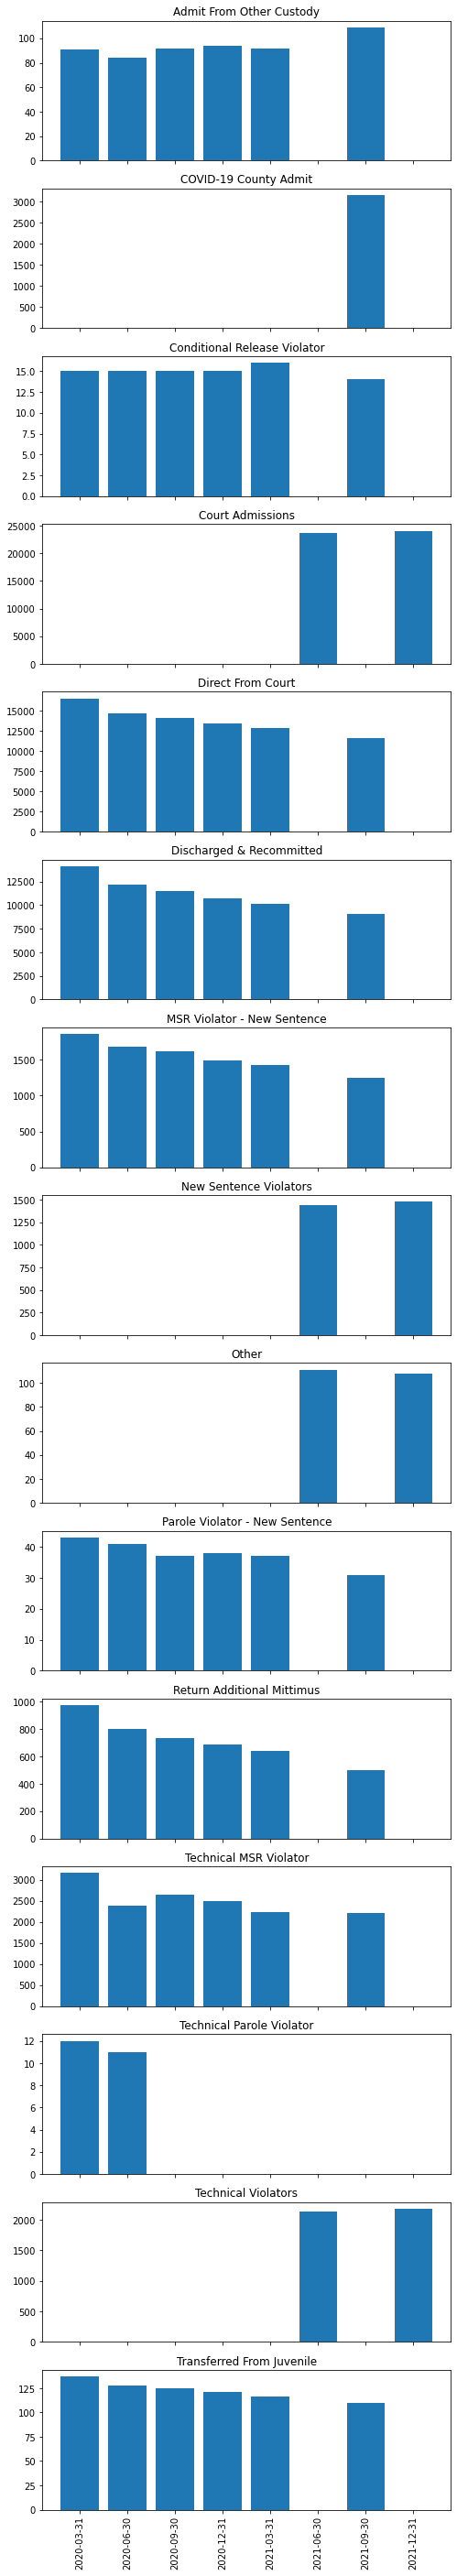

In [15]:
change_df = df[df['Doc Date'] >= date(2020, 1, 1)]

# for recent data, plot the number of individuals with each admission type
plot_df = change_df[['Admission Type', 'Doc Date', 'IDOC #']].groupby(['Admission Type', 'Doc Date']).count().reset_index()

# keep only the admission types with significant numbers
plot_df = plot_df[plot_df['IDOC #'] > 10]

# convert dates to strings
plot_df['Doc Date'] = plot_df['Doc Date'].apply(lambda x: dt.strftime(x, '%Y-%m-%d'))

# get doc_dates for x axis
doc_dates = plot_df[['Doc Date']].drop_duplicates()

# plot bar charts for admission types each quarter
fig, axs = plt.subplots(len(plot_df['Admission Type'].unique()), figsize=(8, 50), sharex=True)#, sharey=True)
i = 0

for at in plot_df['Admission Type'].unique():
    # get the relevant df ordered by doc date
    at_df = plot_df[plot_df['Admission Type'] == at]
    at_df = pd.merge(doc_dates, at_df, on='Doc Date', how='left')
    date_order = sorted(doc_dates['Doc Date'].unique())
    at_df = at_df.set_index(at_df['Doc Date']).loc[date_order]
    
    # plot the relevant df
    axs[i].bar(at_df['Doc Date'], at_df['IDOC #'])
    axs[i].title.set_text(at)
    
    i += 1
    
plt.xticks(rotation=90)
plt.show()



For Jun and Dec 2021 (and going forward?), IDOC used different labels.
* Before Jun 2021
    * Direct From Court
    * Admit From Other Custody
    * MSR Violator - New Sentence
    * Parole Violator - New Sentence
    * Discharged & Recommitted
    * Conditional Release Violator
    * Technical MSR Violator
    * Technical Parole Violator
    * Transferred from Juvenile
    * Return Additional Mittimus
    * COVID-19 County Admit
* Jun and Dec 2021
    * Court Admissions
    * New Sentence Violators
    * Technical Violators
    * Other

In [16]:
# prep data for a sankey diagram to show the relationship between the labels in the two time periods

sankey_df = df[df['Doc Date'] >= date(2021, 3, 1)]
sankey_df = sankey_df[sankey_df['Admission Type'] != 'None']

# convert dates to strings
sankey_df['Doc Date'] = sankey_df['Doc Date'].apply(lambda x: dt.strftime(x, '%Y-%m-%d'))

# break into before and after
sankey_df = sankey_df[['IDOC #', 'Current Admission Date', 'Admission Type', 'Doc Date']].drop_duplicates()
after_df = sankey_df[sankey_df['Doc Date'].isin(['2021-06-30', '2021-12-31'])]
before_df = sankey_df[~sankey_df.index.isin(after_df.index)]

# recombine with before and after columns
after_df = after_df.drop('Doc Date', axis=1).rename(columns={'Admission Type': 'After Admission Type'})
before_df = before_df.drop('Doc Date', axis=1).rename(columns={'Admission Type': 'Before Admission Type'})
sankey_df = pd.merge(before_df, after_df, on=['IDOC #', 'Current Admission Date'], how='outer')

# drop dupes and count totals for each before/after combo
sankey_df = sankey_df.drop_duplicates()[['Before Admission Type', 'After Admission Type', 'IDOC #']].groupby(['Before Admission Type', 'After Admission Type']).count().reset_index().rename(columns={'IDOC #': 'Count'})
print(sankey_df)

# get the node df - a df dictionary of admission types and indices
node_df = pd.concat([sankey_df[['Before Admission Type']].rename(columns={'Before Admission Type': 'AT'}),
                       sankey_df[['After Admission Type']].rename(columns={'After Admission Type': 'AT'})])
node_df = node_df.drop_duplicates().reset_index(drop=True).reset_index().rename(columns={'index': 'ID'})
node_df['Color'] = get_hex(len(node_df))

# get the links df
links_df = pd.merge(sankey_df, 
                    node_df[['AT', 'ID', 'Color']].rename(columns={'ID': 'Source', 'Color': 'Link Color'}), 
                    left_on='Before Admission Type', right_on='AT', how='inner')
links_df = pd.merge(links_df, 
                    node_df[['AT', 'ID']].rename(columns={'ID': 'Target'}), 
                    left_on='After Admission Type', right_on='AT', how='inner')
links_df['Link Color'] = links_df['Link Color'].apply(lambda x: 'rgba' + str(get_rgb_from_hex(x) + (0.5,)))
links_df = links_df[['Source', 'Target', 'Link Color', 'Count']]



             Before Admission Type    After Admission Type  Count
0         Admit From Other Custody        Court Admissions     11
1         Admit From Other Custody                   Other    100
2            COVID-19 County Admit        Court Admissions   2770
3            COVID-19 County Admit  New Sentence Violators    195
4            COVID-19 County Admit     Technical Violators      2
5     Conditional Release Violator                   Other     15
6                Direct From Court        Court Admissions  12674
7         Discharged & Recommitted        Court Admissions  10160
8      MSR Violator - New Sentence        Court Admissions      1
9      MSR Violator - New Sentence  New Sentence Violators   1399
10     MSR Violator - New Sentence     Technical Violators      7
11             Not In IDOC Custody                   Other      1
12  Parole Violator - New Sentence  New Sentence Violators     35
13      Return Additional Mittimus        Court Admissions    601
14        

In [25]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 20,
        thickness = 30,
        line = dict(
            color = 'black',
            width = 0
        ),
        label = node_df['AT'],
        color = node_df['Color']
    ),
    link = dict(
        source = links_df['Source'],
        target = links_df['Target'],
        value = links_df['Count'],
        color = links_df['Link Color']
    )
)])

fig.update_layout(title_text='Change in Admission Type in Jun and Dec 2021',
                  height=1000,
                  font_size=12)
fig.show()

For the most part, the new admission types group multiple old admission types.
* Court Admissions
    * Direct From Court
    * Discharged & Recommitted
    * Return Additional Mittimus
    * COVID-19 County Admit (but let's keep this as its own since its timeframe is so limited)
    * Transferred From Juvenile
* Other
    * Admit from Other Custody
    * Conditional Release Violator
    * Not In IDOC Custody
    * Return To Custody
* New Sentence Violators
    * MSR Violator - New Sentence
    * Parole Violator - New Sentence
* Technical Violators
    * Technical MSR Violator
    * Technical Parole Violator
    
Let's create a new field with the new admission types grouping the old admission types. Group others (from past quarters) based on similarity to other old admission types.


In [26]:
ct_admis_list = ['Direct From Court', 'Discharged & Recommitted', 'Return Additional Mittimus', 'Transferred From Juvenile']
other_list = ['Admit From Other Custody', 'Conditional Release Violator', 'Not In IDOC Custody', 'Return To Custody', 'Work Release Violator', 'EDV', 'Juv Parole To Adult Parole']
new_sent_viol_list = ['MSR Violator - New Sentence', 'Parole Violator - New Sentence', 'Conditional Release - New Sentence', 'Work Release Violator - New Sentence']
tech_viol_list = ['Technical MSR Violator', 'Technical Parole Violator']

df['New Admission Type'] = None
df.loc[df['Admission Type'].isin(ct_admis_list), 'New Admission Type'] = 'Court Admissions'
df.loc[df['Admission Type'].isin(other_list), 'New Admission Type'] = 'Other'
df.loc[df['Admission Type'].isin(new_sent_viol_list), 'New Admission Type'] = 'New Sentence Violators'
df.loc[df['Admission Type'].isin(tech_viol_list), 'New Admission Type'] = 'Technical Violators'

df.loc[pd.isnull(df['New Admission Type']), 'New Admission Type'] = df.loc[pd.isnull(df['New Admission Type']), 'Admission Type']

print(df['New Admission Type'].value_counts().sort_index())



COVID-19 County Admit        3147
Court Admissions          1360536
New Sentence Violators     134362
Other                        4429
Technical Violators        169463
Name: New Admission Type, dtype: int64


**Admission Type**

Bucket into first-time vs. second-time vs. technical offender. (This might be outdated with the sentence number recidivism measure.)

In [27]:
first_list = ['DIRECT FROM COURT', 'TRANSFERRED FROM JUVENILE', 'JUV PAROLE TO ADULT PAROLE']
second_list = ['DISCHARGED & RECOMMITTED', 'MSR VIOLATOR - NEW SENTENCE', 'PAROLE VIOLATOR - NEW SENTENCE', 'WORK RELEASE VIOLATOR - NEW SENTENCE', 'CONDITIONAL RELEASE - NEW SENTENCE']
tech_list = ['TECHNICAL PAROLE VIOLATOR', 'TECHNICAL MSR VIOLATOR', 'CONDITIONAL RELEASE VIOLATOR', 'TECHNICAL VIOLATORS', 'WORK RELEASE VIOLATOR']

df['Admission Type - Recidivism'] = None
df.loc[df['Admission Type'].str.upper().isin(first_list), 'Admission Type - Recidivism'] = 'First IDOC Sentence'
df.loc[df['Admission Type'].str.upper().isin(second_list), 'Admission Type - Recidivism'] = 'Second/+ IDOC Sentence'
df.loc[df['Admission Type'].str.upper().isin(tech_list), 'Admission Type - Recidivism'] = 'Technical MSR/Parole Violator'

df.loc[pd.isnull(df['Admission Type - Recidivism']), 'Admission Type - Recidivism'] = 'Unknown/Uncategorized'

print(df['Admission Type - Recidivism'].value_counts())

# df8 = df.copy()


Second/+ IDOC Sentence           714854
First IDOC Sentence              705198
Technical MSR/Parole Violator    169922
Unknown/Uncategorized            124057
Name: Admission Type - Recidivism, dtype: int64


**Eligibility for Sentencing Credits**

For the purposes of our analysis, someone is *ineligible* for earned discretionary sentencing credits (EDSC) if:
* Their holding offense is related to gunrunning or sex
* They're sentenced to life
* They're required to serve at least 85% of their sentence under truth-in-sentencing
* They're considered a sexually dangerous person (SDP)

Otherwise, they are eligible.

In [28]:
df['EDSC Eligible'] = None
df.loc[(((df['TIS Pct'] >= 0.85) & (~pd.isnull(df['TIS Pct'])))
      | df['Holding Offense'].str.contains('GUNRUNNING')
      | df['Sentence Years'].isin(['LIFE', 'SDP'])
      | df['Holding Offense Cat'] == 'Sex'),
      'EDSC Eligible'] = 'N'
df.loc[pd.isnull(df['EDSC Eligible']), 'EDSC Eligible'] = 'Y'

# df9 = df.copy()



**Exporting the data**

The full data set is 1.7 million records. Export with understanding.

In [29]:
print(len(df))

1714031


In [30]:
# export more recent data
df_recent = df[df['Doc Date'] >= date(2014, 1, 1)]
print(len(df_recent))

# # export single institution all time
# df_export = df[df['Parent Institution'] == 'Logan']
# print(len(df_export))


919482


In [ ]:
# df_recent.to_csv('pop_data_20140101-20211231.csv')